In [1]:
import os
import sys
import random
import json
import collections
import itertools

import pandas as pd
import numpy as np
import scipy        
import statsmodels


from tqdm import trange, tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = 999

sns.set()

plt.rcParams["figure.figsize"] = (10,7)

In [2]:
os.getcwd()

'/notebooks/anton/sigmod/notebooks'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from sigmod_src.utils import read_json, pprint_json, path_from_spec_id, get_vector_for_spec_id
from sigmod_src.data.embedding import Embedder

# Load data

In [5]:
LABELS_PATH = '../data/raw/sigmod_medium_labelled_dataset.csv'

In [6]:
labels_df = pd.read_csv(LABELS_PATH)

In [7]:
labels_df.shape

(46665, 3)

In [8]:
labels_df.head()

,left_spec_id,right_spec_id,label
0,www.garricks.com.au//31,www.ebay.com//53278,1
1,www.ebay.com//58782,www.ebay.com//24817,0
2,www.ebay.com//58782,www.ebay.com//43019,0
3,www.ebay.com//42055,www.ebay.com//54403,0
4,www.ebay.com//44280,buy.net//6145,0


In [9]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46665 entries, 0 to 46664
Data columns (total 3 columns):
left_spec_id     46665 non-null object
right_spec_id    46665 non-null object
label            46665 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


# Load specs df

In [10]:
specs_df = pd.read_csv('../data/processed/specs_preprocessed.csv')
# specs_df.index=  specs_df.spec_id
specs_df.shape

(29771, 5)

In [11]:
specs_df[specs_df.page_title.isnull()]

,spec_id,page_title,page_title_stem,brand,site


In [12]:
specs_df.head()

,spec_id,page_title,page_title_stem,brand,site
0,www.flipkart.com//2249,lowepro fastpack 350 bag lowepro,lowepro fastpack 350 bag lowepro,NaN,www.flipkart.com
1,www.flipkart.com//2199,nikon coolpix l30 point shoot,nikon coolpix l30 point shoot,nikon,www.flipkart.com
2,www.flipkart.com//2286,sony point shoot,soni point shoot,sony,www.flipkart.com
3,www.flipkart.com//2280,lowepro compu day photo 250 multi use backpack...,lowepro compu day photo 250 multi use backpack...,NaN,www.flipkart.com
4,www.flipkart.com//2279,nikon l29 point shoot india,nikon l29 point shoot india,nikon,www.flipkart.com


# Classes df

In [13]:
classes_df = pd.read_csv('../data/interim/classes.csv')
# classes_df.index = classes_df.spec_id
classes_df = classes_df.drop(columns='spec_id.1')
classes_df.head()


,spec_id,class_
0,buy.net//5641,0
1,www.ebay.com//58588,0
2,www.gosale.com//849,0
3,www.price-hunt.com//9794,0
4,buy.net//5698,1


## Add classes to specs

In [14]:
specs_df = specs_df.merge(classes_df, how='left')
specs_df.head()

,spec_id,page_title,page_title_stem,brand,site,class_
0,www.flipkart.com//2249,lowepro fastpack 350 bag lowepro,lowepro fastpack 350 bag lowepro,NaN,www.flipkart.com,NaN
1,www.flipkart.com//2199,nikon coolpix l30 point shoot,nikon coolpix l30 point shoot,nikon,www.flipkart.com,NaN
2,www.flipkart.com//2286,sony point shoot,soni point shoot,sony,www.flipkart.com,NaN
3,www.flipkart.com//2280,lowepro compu day photo 250 multi use backpack...,lowepro compu day photo 250 multi use backpack...,NaN,www.flipkart.com,NaN
4,www.flipkart.com//2279,nikon l29 point shoot india,nikon l29 point shoot india,nikon,www.flipkart.com,NaN


In [15]:
specs_df[specs_df.class_ == 0]

,spec_id,page_title,page_title_stem,brand,site,class_
9274,buy.net//5641,nikon d4 body,nikon d4 bodi,nikon,buy.net,0.0
10828,www.price-hunt.com//9794,nikon d4 best india 2014,nikon d4 best india 2014,nikon,www.price-hunt.com,0.0
12808,www.ebay.com//58588,nikon d4 16 2 mp body,nikon d4 16 2 mp bodi,nikon,www.ebay.com,0.0
13253,www.ebay.com//59612,excellent nikon d4 body 16 2 mp fx free,excel nikon d4 bodi 16 2 mp fx free,nikon,www.ebay.com,0.0
16498,www.ebay.com//54217,near mint nikon d4 body 16 2 mp fx,near mint nikon d4 bodi 16 2 mp fx,nikon,www.ebay.com,0.0
29133,www.gosale.com//849,nikon d4 cmos fx sale,nikon d4 cmos fx sale,nikon,www.gosale.com,0.0


In [16]:
specs_df[specs_df.class_ == 0]

,spec_id,page_title,page_title_stem,brand,site,class_
9274,buy.net//5641,nikon d4 body,nikon d4 bodi,nikon,buy.net,0.0
10828,www.price-hunt.com//9794,nikon d4 best india 2014,nikon d4 best india 2014,nikon,www.price-hunt.com,0.0
12808,www.ebay.com//58588,nikon d4 16 2 mp body,nikon d4 16 2 mp bodi,nikon,www.ebay.com,0.0
13253,www.ebay.com//59612,excellent nikon d4 body 16 2 mp fx free,excel nikon d4 bodi 16 2 mp fx free,nikon,www.ebay.com,0.0
16498,www.ebay.com//54217,near mint nikon d4 body 16 2 mp fx,near mint nikon d4 bodi 16 2 mp fx,nikon,www.ebay.com,0.0
29133,www.gosale.com//849,nikon d4 cmos fx sale,nikon d4 cmos fx sale,nikon,www.gosale.com,0.0


In [17]:
labelled_specs_df = specs_df[~specs_df.class_.isnull()]

In [546]:
labelled_specs_df.to_csv('../data/interim/specs_df_labelled.csv', index=None)

In [141]:
from sklearn.model_selection import train_test_split
lstr, lste = train_test_split(labelled_specs_df, test_size=0.3)
print(lstr.shape, lste.shape)

(214, 6) (92, 6)


In [142]:
lstr.to_csv('../data/interim/specs_df_labelled_train.csv', index=None)
lste.to_csv('../data/interim/specs_df_labelled_test.csv', index=None)

# Triplet generator

In [549]:
labelled_specs_df['spec_idx'] = range(len(labelled_specs_df))
labelled_specs_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,spec_id,page_title,page_title_stem,brand,site,class_,spec_idx
91,www.flipkart.com//2178,nikon coolpix l30 point shoot,nikon coolpix l30 point shoot,nikon,www.flipkart.com,12.0,0
150,www.flipkart.com//2193,canon eos 1200d kit ef ii,canon eo 1200d kit ef ii,canon,www.flipkart.com,21.0,1
162,www.priceme.co.nz//1778,nikon d3200 zealand prices priceme,nikon d3200 zealand price pricem,nikon,www.priceme.co.nz,1.0,2
194,www.priceme.co.nz//1746,nikon d90 vr ii zealand prices,nikon d90 vr ii zealand price,nikon,www.priceme.co.nz,14.0,3
199,www.priceme.co.nz//54,canon eos 7d mark ii zealand prices priceme,canon eo 7d mark ii zealand price pricem,canon,www.priceme.co.nz,9.0,4


In [40]:
spec_lookup = labelled_specs_df.groupby(['class_'])['spec_idx'].agg(list).to_dict()
spec_lookup[0]

[24, 45, 73, 80, 122, 296]

In [41]:
class_lookup = labelled_specs_df[~labelled_specs_df.class_.isnull()].set_index('spec_idx').to_dict()['class_']
class_lookup[143]

23.0

In [18]:
def gen_triplet(anchor_ids, class_lookup_table, id_lookup_table, batch_size=1):
    pos_ids = []
    neg_ids = []
    for i in enumerate(anchor_ids):
        anchor_class = class_lookup_table[anchor_id]
        positive_id = random.choice(list(set(id_lookup_table[anchor_class]).difference(set([anchor_id]))))

        negative_class = random.choice(list(set(id_lookup_table.keys()).difference([anchor_class])))
        negative_id = random.choice(id_lookup_table[negative_class])
        
    return (anchor_id, positive_id, negative_id)

In [176]:
%%time
labelled_specs_df.iloc[list(gen_triplet(1, class_lookup, spec_lookup))]

CPU times: user 1.08 ms, sys: 0 ns, total: 1.08 ms
Wall time: 1.03 ms


,spec_id,page_title,page_title_stem,brand,site,class_,spec_idx
150,www.flipkart.com//2193,canon eos 1200d kit ef ii,canon eo 1200d kit ef ii,canon,www.flipkart.com,21.0,1
651,www.priceme.co.nz//2246,canon eos 1200d zealand prices priceme,canon eo 1200d zealand price pricem,canon,www.priceme.co.nz,21.0,15
11929,www.ebay.com//41954,canon eos 20d 8 2 mp,canon eo 20d 8 2 mp,canon,www.ebay.com,6.0,63


# Triplet loss model

In [19]:
import torch
import torchtext
from torchtext.datasets import text_classification
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
from torch.utils.data.dataset import random_split
import torch.optim as optim

In [20]:
from torchtext.data import Field

In [21]:
from torchtext.data import Dataset, TabularDataset

In [22]:
DEVICE = 'cuda'
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [23]:
tokenize = lambda x: x.split()
text_field = Field(sequential=True, tokenize=tokenize, lower=True)
brand_field = Field(sequential=False, use_vocab=True, lower=True)
site_field = Field(sequential=False, use_vocab=True, lower=True)

In [161]:
%%time
PATH = '../data/interim/'
TRAIN_PATH = 'specs_df_labelled_train.csv'
TEST_PATH = 'specs_df_labelled_test.csv'

datafields = [("spec_id", None),
              ("page_title", None),
                 ("page_title_stem", text_field),
                  ("brand", brand_field),
                  ("site", site_field),
             ('class_', None)]

train_dataset, test_dataset = TabularDataset.splits(
        path=PATH, # the root directory where the data lies
        train=TRAIN_PATH,
        test=TEST_PATH,
        format='csv',
        skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
        fields=datafields)

CPU times: user 8.01 ms, sys: 42 µs, total: 8.05 ms
Wall time: 7.91 ms


In [25]:
%%time
text_field.build_vocab(train_dataset)
site_field.build_vocab(train_dataset)
brand_field.build_vocab(train_dataset)

CPU times: user 4.09 ms, sys: 232 µs, total: 4.32 ms
Wall time: 4.34 ms


In [26]:
class BiLSTMEmbedder(nn.Module):
    def __init__(self, hidden_dim, emb_dim=300,
                 spatial_dropout=0.05, recurrent_dropout=0.1, num_linear=1, num_lstm=1, device='cpu'):
        super().__init__()
        self.embedding = nn.Embedding(len(text_field.vocab), emb_dim)
        self.encoder = nn.LSTM(emb_dim, hidden_dim, num_layers=num_lstm, 
                               dropout=recurrent_dropout)
#         self.conv1d = nn.Conv1d(emb_dim, hidden_dim, 10, )
        self.linear_layers = []
        self.deivce = device
        for _ in range(num_linear - 1):
            self.linear_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.linear_layers = nn.ModuleList(self.linear_layers)
    
    def forward(self, seq):
        hdn, _ = self.encoder(self.embedding(seq))
        feature = hdn[-1, :, :]
        for layer in self.linear_layers:
            feature = layer(feature)
        return feature.to(self.deivce)

In [27]:
emb_dim = 300
hidden_dim = 200
num_linear = 3
num_lstm = 1
model = BiLSTMEmbedder(hidden_dim, emb_dim=emb_dim, num_linear=num_linear, num_lstm=num_lstm, recurrent_dropout=0, device=DEVICE)

model

BiLSTMEmbedder(
  (embedding): Embedding(249, 300)
  (encoder): LSTM(300, 200)
  (linear_layers): ModuleList(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=200, bias=True)
  )
)

### data preparation

In [28]:
def gen_triplet(anchor_id, class_lookup_table, id_lookup_table):

    anchor_class = class_lookup_table[anchor_id]
    positive_id = random.choice(list(set(id_lookup_table[anchor_class]).difference(set([anchor_id]))))

    negative_class = random.choice(list(set(id_lookup_table.keys()).difference([anchor_class])))
    negative_id = random.choice(id_lookup_table[negative_class])

    return (anchor_id, positive_id, negative_id)

In [143]:
train_labelled_df = pd.read_csv(os.path.join(PATH, TRAIN_PATH))
train_labelled_df['spec_idx'] = range(len(train_labelled_df))

train_class_lookup = train_labelled_df[~train_labelled_df.class_.isnull()].set_index('spec_idx').to_dict()['class_']
train_spec_lookup = train_labelled_df.groupby(['class_'])['spec_idx'].agg(list).to_dict()

In [144]:
test_labelled_df = pd.read_csv(os.path.join(PATH, TEST_PATH))
test_labelled_df['spec_idx'] = range(len(test_labelled_df))

test_class_lookup = test_labelled_df[~test_labelled_df.class_.isnull()].set_index('spec_idx').to_dict()['class_']
test_spec_lookup = test_labelled_df.groupby(['class_'])['spec_idx'].agg(list).to_dict()

In [196]:
# если количество элементов в датасете не делится нацело на количество батчей, то последний батч удаляется

def triplet_iterator(dataset, class_lookup, spec_lookup, batch_size=1):
    shuffled_idx = np.arange(len(dataset))
    np.random.shuffle(shuffled_idx)
    
    
    num_drop = len(shuffled_idx) % batch_size
    shuffled_idx = shuffled_idx[:-num_drop] if num_drop != 0 else shuffled_idx
    shuffled_idx = shuffled_idx.reshape(-1, batch_size)
    for idxs in shuffled_idx:
        list_triplets = []
        for i in idxs:
            try:
                _, pos_idx, neg_idx = gen_triplet(i, class_lookup, spec_lookup)
            except IndexError:
#                 print('!!!!!!', i)
                continue
            list_triplets.extend([dataset[i].page_title_stem, 
                                  dataset[pos_idx].page_title_stem,
                                  dataset[neg_idx].page_title_stem])
        #паддим все к одному размеру
#         print(list_triplets)
        triplet = text_field.pad(list_triplets)
        triplet = text_field.numericalize(triplet)
        yield triplet
           
next(iter(triplet_iterator(train_dataset, train_class_lookup, train_spec_lookup, 1)))

tensor([[  2,   2,   2],
        [ 27,  27,  27],
        [ 62,  62,  40],
        [ 42,  42, 208],
        [168,   0,  37],
        [193,   1,  25],
        [  1,   1,  43]])

In [221]:
def triplet_loss(anchor, pos, neg, margin=0.8):
    """
    Consine similarity for between anchor and positive should be >= 0.8
    
    Cosine similarity for negative should be < 0.8
    """
    pos_dist = F.cosine_similarity(anchor, pos, dim=1)
    neg_dist = F.cosine_similarity(anchor, neg, dim=1)
    
    loss_pos = torch.clamp(margin-pos_dist, min=0)
    loss_neg = torch.clamp(neg_dist-margin, min=0)
    return torch.sum(loss_pos + loss_neg)

In [225]:
loss_history_train = []
loss_history_test = []

opt = optim.Adam(model.parameters(), lr=1e-3)
epochs = 30

### train

In [227]:
%%time
loss_history = []
for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    
    running_loss = 0
    count_triplets = 0
    
    for triplet in iter(triplet_iterator(train_dataset, train_class_lookup, train_spec_lookup, batch_size=10)):
        opt.zero_grad()

        embeddings = model(triplet)
        anchors = embeddings[0::3]
        pos = embeddings[1::3]
        ng = embeddings[2::3]
        loss = triplet_loss(anchors, pos, ng)
        loss.backward()
        opt.step()
        
        running_loss += loss.data
        count_triplets +=1 
        
        
    epoch_loss = running_loss / count_triplets
    loss_history.append(epoch_loss)
    
    print('Epoch: {}, Training Loss: {:.4f}'.format(epoch, epoch_loss))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch: 1, Training Loss: 0.7151
Epoch: 2, Training Loss: 0.4511
Epoch: 3, Training Loss: 0.2430
Epoch: 4, Training Loss: 0.2041
Epoch: 5, Training Loss: 0.1243
Epoch: 6, Training Loss: 0.1001
Epoch: 7, Training Loss: 0.0797
Epoch: 8, Training Loss: 0.0733
Epoch: 9, Training Loss: 0.0758
Epoch: 10, Training Loss: 0.0486
Epoch: 11, Training Loss: 0.0250
Epoch: 12, Training Loss: 0.0430
Epoch: 13, Training Loss: 0.0183
Epoch: 14, Training Loss: 0.0221
Epoch: 15, Training Loss: 0.0153
Epoch: 16, Training Loss: 0.0088
Epoch: 17, Training Loss: 0.0098
Epoch: 18, Training Loss: 0.0231
Epoch: 19, Training Loss: 0.0099
Epoch: 20, Training Loss: 0.0176
Epoch: 21, Training Loss: 0.0174
Epoch: 22, Training Loss: 0.0057
Epoch: 23, Training Loss: 0.0064
Epoch: 24, Training Loss: 0.0060
Epoch: 25, Training Loss: 0.0034
Epoch: 26, Training Loss: 0.0091
Epoch: 27, Training Loss: 0.0058
Epoch: 28, Training Loss: 0.0015
Epoch: 29, Training Loss: 0.0059
Epoch: 30, Training Loss: 0.0030

CPU times: user 10

### test

In [228]:
%%time
model.eval()

test_loss = 0
count_test = 0
test_loss_h = []
with torch.no_grad():
    for triplet in iter(triplet_iterator(test_dataset, test_class_lookup, test_spec_lookup, batch_size=2)):
        embeddings = model(triplet)
        anchors = embeddings[0::3]
        pos = embeddings[1::3]
        ng = embeddings[2::3]
        loss = triplet_loss(anchors, pos, ng)
        test_loss += loss.data
        count_test +=1 

print('Test Loss: {:.4f}'.format(test_loss / count_test))

Test Loss: 0.0285
CPU times: user 2.79 s, sys: 0 ns, total: 2.79 s
Wall time: 118 ms


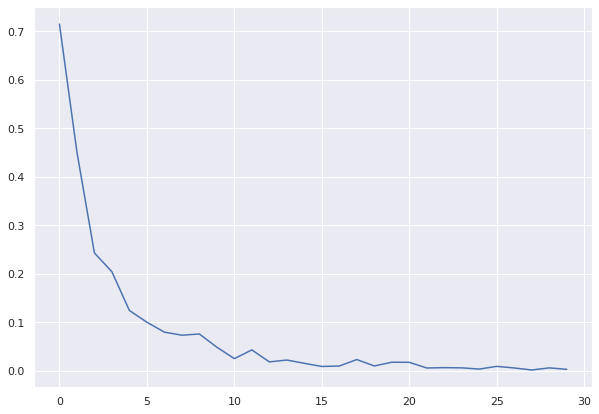

In [229]:
plt.figure()
plt.plot(loss_history, label='loss')
plt.show()

# Produce embeddings and TSNE

In [230]:
embeddings = []
classes = []
for ex in tqdm(train_dataset):
    emb = np.array(model(text_field.numericalize([ex.page_title_stem]))[0].data.cpu().numpy())
    
    embeddings.append(emb)
embeddings = np.array(embeddings)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [231]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [232]:
tsne = TSNE(
    n_components=2,
    metric='cosine',
    n_jobs=3,
    verbose=True,
)

In [233]:
emb_ld = tsne.fit_transform(embeddings)

In [234]:
labelled_spec_classes = labelled_specs_df.class_
labelled_spec_classes = labelled_spec_classes.reset_index()
labelled_spec_classes.shape

(306, 2)

In [235]:
emb_tdf = pd.DataFrame(emb_ld)
emb_tdf = pd.concat([emb_tdf, labelled_spec_classes], axis=1, ignore_index=True)
emb_tdf.columns = ['x', 'y', 'original_index', 'class_']
emb_tdf.head()

,x,y,original_index,class_
0,-4.407661,5.263122,91,12.0
1,-16.198969,-2.058035,150,21.0
2,-0.960544,-3.904778,162,1.0
3,6.916752,-1.503675,194,14.0
4,-2.641135,4.693935,199,9.0


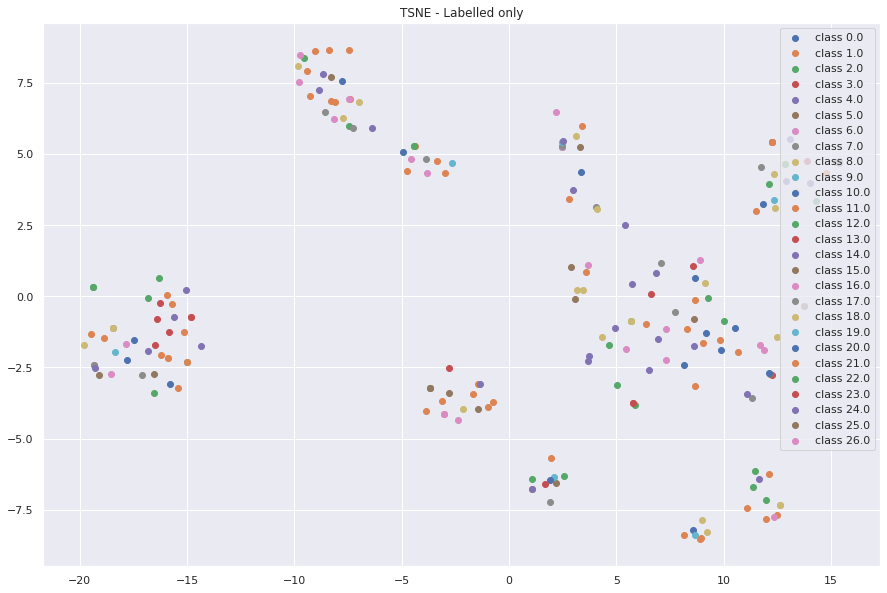

In [236]:
plt.figure(figsize=(15, 10))
plt.title('TSNE - Labelled only')
for class_ in emb_tdf['class_'].sort_values().unique():
    class_ld_df = emb_tdf[emb_tdf.class_==class_]
    plt.scatter(class_ld_df.iloc[:, 0], class_ld_df.iloc[:, 1], label=f'class {class_}')

plt.legend()
plt.show()